In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import torch 

seed = 2023
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
import dolfin as df
import time
from utils import *
from utils_training import *
import prepare_data
from utils_compare_methods import *
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from prepare_data import rotate, outside_ball
import pandas as pd
import gc

sns.set_theme()
sns.set_context("paper")
colors = sns.color_palette("mako").as_hex()
my_cmap = sns.color_palette("viridis", as_cmap=True)

%load_ext autoreload
%autoreload 2


In [ ]:
save_figs = True
small_data = False
data = DataLoader(small_data)
agent = Agent(
    data,
    level=2,
    relative=True,
    squared=False,
    initial_lr=5e-3,
    n_modes=10,
    width=20,
    batch_size=32,
    pad_prop=0.05,
    pad_mode="reflect",
    l2_lambda=1e-3,
)

model = agent.model
device = agent.device

models_repo = "./models"
images_repo = "./images"
best_model = torch.load(f"{models_repo}/best_model.pkl")
model.load_state_dict(best_model["model_state_dict"])
model.eval()

print(f"Best epoch = {best_model['epoch']}")
if not (os.path.exists(f"{images_repo}/")) and save_figs:
    os.makedirs(f"{images_repo}/")

# Compare the errors of $\phi$-FEM, standard FEM and FNO with respect to a reference fine standard FEM solution

In [ ]:
def compare_std_phi_fem_and_fno(param, Plot=False):
    standard_solver = StandardFEMSolver(params=param)
    solver = PhiFemSolver_error(nb_cell=64 - 1, params=param)
    mu0, mu1, sigma_x, sigma_y, amplitude, x_0, y_0, lx, ly, theta, alpha, beta = param[
        0
    ]

    u_ref, V_ref, dx_ref = standard_solver.solve_one(0, 0.002, reference_fem=True)
    (
        u_phi_fem,
        V_phi_fem,
        dx_phi_fem,
        _h_phi,
        cell_selection_phi,
        submesh_construction_phi,
        ghost_cell_selection_phi,
        resolution_time_phi,
    ) = solver.solve_one(0)

    (
        u_std,
        _h_std,
        construction_time_standard,
        resolution_time_standard,
    ) = standard_solver.solve_one(0, 0.0224, reference_fem=False)

    F = generate_F_numpy(mu0, mu1, sigma_x, sigma_y, amplitude, 64)
    G = generate_G_numpy(alpha, beta, 64)
    phi = generate_phi_numpy(x_0, y_0, lx, ly, theta, 64)
    X = generate_manual_new_data_numpy(F, phi, G).to(device)
    x_normed = data.x_normalizer.encode(X)
    start_call = time.time()
    Y_normed = model(x_normed)
    end_call = time.time()
    time_fno = end_call - start_call
    Y = data.y_normalizer.decode(Y_normed)
    predicted_solution = (
        (X[:, 1, :, :] * Y[:, 0, :, :] + X[:, 2, :, :]).cpu().detach().numpy()
    )
    predicted_solution = np.reshape(predicted_solution, (64, 64))
    predicted_sol_fenics = convert_numpy_matrix_to_fenics(predicted_solution, 64, 1)

    u_phi_fem_proj = df.project(
        u_phi_fem,
        V_ref,
        solver_type="gmres",
        preconditioner_type="hypre_amg",
    )

    l2_error_phi_fem = (
        df.assemble((((u_ref - u_phi_fem_proj)) ** 2) * dx_ref) ** (0.5)
    ) / (df.assemble((((u_ref)) ** 2) * dx_ref) ** (0.5))

    u_std_fem_proj = df.project(
        u_std, V_ref, solver_type="gmres", preconditioner_type="hypre_amg"
    )
    l2_error_std_fem = (
        df.assemble((((u_ref - u_std_fem_proj)) ** 2) * dx_ref) ** (0.5)
    ) / (df.assemble((((u_ref)) ** 2) * dx_ref) ** (0.5))

    predicted_sol_fenics_proj_V_ref = df.project(
        predicted_sol_fenics,
        V_ref,
        solver_type="gmres",
        preconditioner_type="hypre_amg",
    )

    l2_error_fno = (
        df.assemble((((u_ref - predicted_sol_fenics_proj_V_ref)) ** 2) * dx_ref)
        ** (0.5)
    ) / (df.assemble((((u_ref)) ** 2) * dx_ref) ** (0.5))

    if Plot:
        plt.figure(figsize=(16, 4))

        ax1 = plt.subplot(141)
        img = df.plot(u_ref, mode="color", cmap=my_cmap)
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("bottom", size="5%", pad=0.3)
        ax1.grid(False)
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.set_title("Reference solution", fontsize=15)
        plt.colorbar(img, cax=cax, orientation="horizontal")

        ax2 = plt.subplot(142)
        img = df.plot(u_phi_fem_proj, mode="color", cmap=my_cmap)
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("bottom", size="5%", pad=0.3)
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.grid(False)
        ax2.set_title(
            "$\phi$-FEM solution \n$L^2$ relative error : " + f"{l2_error_phi_fem:.5f}",
            fontsize=15,
        )
        plt.colorbar(img, cax=cax, orientation="horizontal")

        ax3 = plt.subplot(143)
        img = df.plot(u_std_fem_proj, mode="color", cmap=my_cmap)
        divider = make_axes_locatable(ax3)
        cax = divider.append_axes("bottom", size="5%", pad=0.3)
        ax3.grid(False)
        ax3.set_xlim(0, 1)
        ax3.set_ylim(0, 1)
        ax3.set_title(
            "Standard FEM solution \n$L^2$ relative error : "
            + f"{l2_error_std_fem:.5f}",
            fontsize=15,
        )
        plt.colorbar(img, cax=cax, orientation="horizontal")

        ax4 = plt.subplot(144)
        img = df.plot(predicted_sol_fenics_proj_V_ref, mode="color", cmap=my_cmap)
        divider = make_axes_locatable(ax4)
        cax = divider.append_axes("bottom", size="5%", pad=0.3)
        ax4.grid(False)
        ax4.set_xlim(0, 1)
        ax4.set_ylim(0, 1)
        ax4.set_title(
            "Predicted solution \n$L^2$ relative error : " + f"{l2_error_fno:.5f}",
            fontsize=15,
        )
        plt.colorbar(img, cax=cax, orientation="horizontal")
        if Plot and save_figs:
            plt.savefig(f"{images_repo}/example_output_FEMs_FNO.png")
        plt.show()

    print(f"{l2_error_fno=}")
    print(f"{l2_error_phi_fem=}")
    print(f"{l2_error_std_fem=}")

    print(f"{_h_std=}")
    print(f"{_h_phi=}")

    return (
        l2_error_phi_fem,
        l2_error_std_fem,
        l2_error_fno,
        cell_selection_phi,
        submesh_construction_phi,
        ghost_cell_selection_phi,
        resolution_time_phi,
        construction_time_standard,
        resolution_time_standard,
        time_fno,
    )

In [ ]:
from sklearn.decomposition import PCA
import plotly.express as px

pca = PCA(n_components=2)

X = np.load("../data/agentParams.npy")[:1500]  # take only training data
pca.fit(X)
# params_new = np.load(
#     "./data_test_phi_fem_10000/agentParams.npy"
# )  # np.array([[0.5, 0.5, 0.3, 0.3, 25, 0.5, 0.5, 0.325, 0.325, np.pi / 2.0, 1, 0]])
params_new = np.load("../data/agentParams.npy")[1500:]
X = pca.transform(X)
plt.figure()
new_x = pca.transform(params_new)
print(new_x.shape)
plt.plot(new_x[:, 0], new_x[:, 1], "x", c="purple", label="new data")
plt.scatter(X[:, 0], X[:, 1], c="black", marker="o", label="training data")
plt.ylim(-1.2, 1.2)
plt.legend(ncol=2)
plt.xlabel("1st PC")
plt.ylabel("2nd PC")
plt.savefig("./distribution_parameters_pca.png")
plt.show()

In [ ]:
F, phi, G, params = create_FG_numpy(10, 64)
# params = np.array(
#     [[0.5, 0.4, 0.3, 0.25, 22.0, 0.51, 0.4, 0.32, 0.25, np.pi / 3.0, 0.60, -0.4]]
# )
i = 0

for i in range(len(params)):
    (
        l2_error_phi_fem,
        l2_error_std_fem,
        l2_error_fno,
        cell_selection_phi,
        submesh_construction_phi,
        ghost_cell_selection_phi,
        resolution_time_phi,
        construction_time_standard,
        resolution_time_standard,
        time_fno,
    ) = compare_std_phi_fem_and_fno(np.array([params[i]]), True)
    print(f"{l2_error_fno=}")

In [ ]:
save_list_error = True
L2_error_fno, L2_error_phi_fem, L2_error_std_fem = [], [], []
Time_phi, Time_std, Time_fno = [], [], []

F, phi, G, params = create_FG_numpy(300, 64)
indices = list(range(0, len(params)))
for index in indices:
    print(f"Iter : {index+1}/{len(params)}")
    (
        l2_error_phi_fem,
        l2_error_std_fem,
        l2_error_fno,
        cell_selection_phi,
        submesh_construction_phi,
        ghost_cell_selection_phi,
        resolution_time_phi,
        construction_time_standard,
        resolution_time_standard,
        time_fno,
    ) = compare_std_phi_fem_and_fno(np.array([params[index]]), Plot=False)

    L2_error_phi_fem.append(l2_error_phi_fem)
    Time_phi.append(
        [
            cell_selection_phi,
            submesh_construction_phi,
            ghost_cell_selection_phi,
            resolution_time_phi,
        ]
    )
    L2_error_fno.append(l2_error_fno)
    Time_fno.append(time_fno)

    L2_error_std_fem.append(l2_error_std_fem)
    Time_std.append([construction_time_standard, resolution_time_standard])

    if save_list_error:
        np.save(
            f"{models_repo}/L2_error_phi_fem.npy",
            np.array([L2_error_phi_fem]),
        )
        np.save(
            f"{models_repo}/L2_error_std_fem.npy",
            np.array([L2_error_std_fem]),
        )
        np.save(f"{models_repo}/L2_error_fno.npy", np.array([L2_error_fno]))

In [ ]:
L2_error_phi_fem = np.load(f"{models_repo}/L2_error_phi_fem.npy")
L2_error_std_fem = np.load(f"{models_repo}/L2_error_std_fem.npy")
L2_error_fno = np.load(f"{models_repo}/L2_error_fno.npy")

In [ ]:
if not os.path.exists("./data_test_compare_methods/"):
    os.makedirs("./data_test_compare_methods")
np.save("./data_test_compare_methods/F.npy", F)
np.save("./data_test_compare_methods/Phi.npy", phi)
np.save("./data_test_compare_methods/G.npy", G)
np.save("./data_test_compare_methods/params.npy", params)

In [ ]:
error_tab = []
error_tab.append(L2_error_phi_fem)
error_tab.append(L2_error_std_fem)
error_tab.append(L2_error_fno)

abs_str = ["$\phi$-FEM", "Standard FEM", "FNO "]
errors = np.array(error_tab[:])
errors = np.reshape(errors, (3, np.shape(errors)[-1]))
print(np.shape(errors))
dataframe = pd.DataFrame(errors.transpose(), columns=abs_str)

sns.set(font_scale=1.1)

plt.figure(figsize=(6, 4))
sns.boxplot(
    data=dataframe,
    palette="ch:s=.0,rot=0.0,dark=0.5",
    flierprops={"marker": "x", "markerfacecolor": "black"},
)
plt.yscale("log")
plt.xlabel("Method", fontsize=16)
plt.ylabel("Relative $L^2$ error", fontsize=16)
plt.grid(axis="y", visible=True, which="both")

plt.tight_layout()
if save_figs:
    plt.savefig(f"{images_repo}/boxplots_new_data_compare_method.png")
plt.show()

# Plot PhiFEM StdFEM FNO error time (convergence curves)

In [ ]:
def compare_std_phi_fem_and_fno_size_error(
    param, size_std, size_phi_fem, u_ref, V_ref, dx_ref
):
    solver = PhiFemSolver_error(nb_cell=size_phi_fem - 1, params=param)
    (
        u_phi_fem,
        V_phi_fem,
        dx_phi_fem,
        _h_phi,
        cell_selection_phi,
        submesh_construction_phi,
        ghost_cell_selection_phi,
        resolution_time_phi,
    ) = solver.solve_one(0)
    u_phi_fem_proj = df.project(
        u_phi_fem, V_ref, solver_type="gmres", preconditioner_type="hypre_amg"
    )
    l2_error_phi_fem = (
        df.assemble((((u_ref - u_phi_fem_proj)) ** 2) * dx_ref) ** (0.5)
    ) / (df.assemble((((u_ref)) ** 2) * dx_ref) ** (0.5))

    standard_solver = StandardFEMSolver(params=param)
    (
        u_std,
        _h_std,
        mesh_times_std,
        resolution_time_standard,
    ) = standard_solver.solve_one(0, size_std, size_phi_fem, False)
    u_std_fem_proj = df.project(
        u_std, V_ref, solver_type="gmres", preconditioner_type="hypre_amg"
    )
    l2_error_std_fem = (
        df.assemble((((u_ref - u_std_fem_proj)) ** 2) * dx_ref) ** (0.5)
    ) / (df.assemble((((u_ref)) ** 2) * dx_ref) ** (0.5))

    mu0, mu1, sigma_x, sigma_y, amplitude, x_0, y_0, lx, ly, theta, alpha, beta = param[
        0
    ]

    F = generate_F_numpy(mu0, mu1, sigma_x, sigma_y, amplitude, 64)
    G = generate_G_numpy(alpha, beta, 64)
    phi = generate_phi_numpy(x_0, y_0, lx, ly, theta, 64)
    X = generate_manual_new_data_numpy(F, phi, G).to(device)
    x_normed = data.x_normalizer.encode(X)
    start_call = time.time()
    Y_normed = model(x_normed)
    end_call = time.time()
    time_fno = end_call - start_call
    Y = data.y_normalizer.decode(Y_normed)
    predicted_solution = (
        (X[:, 1, :, :] * Y[:, 0, :, :] + X[:, 2, :, :]).cpu().detach().numpy()
    )
    predicted_solution = np.reshape(predicted_solution, (64, 64))
    predicted_solution_fenics = convert_numpy_matrix_to_fenics(
        predicted_solution, 64, 1
    )
    predicted_solution_fenics_proj_V_ref = df.project(
        predicted_solution_fenics,
        V_ref,
        solver_type="gmres",
        preconditioner_type="hypre_amg",
    )

    l2_error_fno = (
        df.assemble((((u_ref - predicted_solution_fenics_proj_V_ref)) ** 2) * dx_ref)
        ** (0.5)
    ) / (df.assemble((((u_ref)) ** 2) * dx_ref) ** (0.5))

    return (
        l2_error_phi_fem,
        l2_error_std_fem,
        l2_error_fno,
        cell_selection_phi,
        submesh_construction_phi,
        ghost_cell_selection_phi,
        resolution_time_phi,
        mesh_times_std,
        resolution_time_standard,
        time_fno,
    )

In [ ]:
F, phi, G, params = create_FG_numpy(20, 64)

In [ ]:
sizes_phi_fem = [16, 32, 64, 128, 256]
sizes_std = []
for size in sizes_phi_fem:
    mesh_tmp = df.UnitSquareMesh(size - 1, size - 1)
    sizes_std.append(mesh_tmp.hmax())
print(
    sizes_std
)  # [0.20203050891044222, 0.09428090415820647, 0.045619792334616084, 0.02244783432338254, 0.01113553986120561, 0.005545935538718157]

In [ ]:
(
    L2_error_phi_fem_array,
    L2_error_std_fem_array,
    L2_error_fno_array,
    Cell_selection_phi_array,
    Submesh_construction_phi_array,
    Ghost_cell_selection_phi_array,
    Resolution_time_phi_array,
    Construction_time_standard_array,
    Resolution_time_standard_array,
    Time_fno_array,
) = (
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
    [],
)

index = 0
u_refs, V_refs, dx_refs = [], [], []

for index in range(len(params)):
    standard_solver = StandardFEMSolver(params=np.array([params[index]]))
    u_ref, V_ref, dx_ref = standard_solver.solve_one(0, 0.001, reference_fem=True)
    u_refs.append(u_ref)
    V_refs.append(V_ref)
    dx_refs.append(dx_ref)
    sizes_phi_fem = [16, 32, 64, 128, 256]
    sizes_std = [
        # 0.20203050891044222,
        0.09428090415820647,
        0.045619792334616084,
        0.02244783432338254,
        0.01113553986120561,
        0.005545935538718157,
    ]

    (
        L2_error_phi_fem,
        L2_error_std_fem,
        L2_error_fno,
        Cell_selection_phi,
        Submesh_construction_phi,
        Ghost_cell_selection_phi,
        Resolution_time_phi,
        Construction_time_standard,
        Resolution_time_standard,
        Time_fno,
    ) = (
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
        [],
    )

    for i in range(len(sizes_phi_fem)):  # size in sizes:
        print(f"Param : {index}/{len(params)}    {sizes_phi_fem[i]=}")
        (
            l2_error_phi_fem,
            l2_error_std_fem,
            l2_error_fno,
            cell_selection_phi,
            submesh_construction_phi,
            ghost_cell_selection_phi,
            resolution_time_phi,
            construction_time_standard,
            resolution_time_standard,
            time_fno,
        ) = compare_std_phi_fem_and_fno_size_error(
            np.array([params[index]]),
            sizes_std[i],
            sizes_phi_fem[i],
            u_ref,
            V_ref,
            dx_ref,
        )

        L2_error_phi_fem.append(l2_error_phi_fem)
        L2_error_std_fem.append(l2_error_std_fem)
        L2_error_fno.append(l2_error_fno)
        Cell_selection_phi.append(cell_selection_phi)
        Submesh_construction_phi.append(submesh_construction_phi)
        Ghost_cell_selection_phi.append(ghost_cell_selection_phi)
        Resolution_time_phi.append(resolution_time_phi)
        Construction_time_standard.append(construction_time_standard)
        Resolution_time_standard.append(resolution_time_standard)
        Time_fno.append(time_fno)

    L2_error_phi_fem_array.append(L2_error_phi_fem)
    L2_error_std_fem_array.append(L2_error_std_fem)
    L2_error_fno_array.append(L2_error_fno)
    Cell_selection_phi_array.append(Cell_selection_phi)
    Submesh_construction_phi_array.append(Submesh_construction_phi)
    Ghost_cell_selection_phi_array.append(Ghost_cell_selection_phi)
    Resolution_time_phi_array.append(Resolution_time_phi)
    Construction_time_standard_array.append(Construction_time_standard)
    Resolution_time_standard_array.append(Resolution_time_standard)
    Time_fno_array.append(Time_fno)

In [ ]:
L2_error_phi_fem_array = np.array(L2_error_phi_fem_array)
L2_error_std_fem_array = np.array(L2_error_std_fem_array)
L2_error_fno_array = np.array(L2_error_fno_array)
Cell_selection_phi_array = np.array(Cell_selection_phi_array)
Submesh_construction_phi_array = np.array(Submesh_construction_phi_array)
Ghost_cell_selection_phi_array = np.array(Ghost_cell_selection_phi_array)
Resolution_time_phi_array = np.array(Resolution_time_phi_array)
Construction_time_standard_array = np.array(Construction_time_standard_array)
Resolution_time_standard_array = np.array(Resolution_time_standard_array)
Time_fno_array = np.array(Time_fno_array)

In [ ]:
sizes_phi_fem_h = []
for size in sizes_phi_fem:
    mesh_macro = df.UnitSquareMesh(size - 1, size - 1)
    h_macro = mesh_macro.hmax()
    sizes_phi_fem_h.append(h_macro)

size_fno = df.UnitSquareMesh(64 - 1, 64 - 1).hmax()

In [ ]:
mean_errors_L2_phi_fem = np.mean(L2_error_phi_fem_array, axis=0)
mean_errors_L2_std_fem = np.mean(L2_error_std_fem_array, axis=0)
mean_errors_L2_FNO = np.mean(L2_error_fno_array, axis=0)

std_errors_L2_phi_fem = np.std(L2_error_phi_fem_array, axis=0)
std_errors_L2_std_fem = np.std(L2_error_std_fem_array, axis=0)
std_errors_L2_FNO = np.std(L2_error_fno_array, axis=0)

min_errors_L2_phi_fem = np.min(L2_error_phi_fem_array, axis=0)
min_errors_L2_std_fem = np.min(L2_error_std_fem_array, axis=0)
min_errors_L2_FNO = np.min(L2_error_fno_array, axis=0)

max_errors_L2_phi_fem = np.max(L2_error_phi_fem_array, axis=0)
max_errors_L2_std_fem = np.max(L2_error_std_fem_array, axis=0)
max_errors_L2_FNO = np.max(L2_error_fno_array, axis=0)

center = [size_fno, mean_errors_L2_FNO[0]]

plt.figure(figsize=(6, 4))
plt.loglog(sizes_std, mean_errors_L2_std_fem, "-+", markersize=8, label="Std-FEM")
ci_error_std_FEM = std_errors_L2_std_fem
plt.fill_between(
    sizes_std,
    mean_errors_L2_std_fem - ci_error_std_FEM,
    mean_errors_L2_std_fem + ci_error_std_FEM,
    alpha=0.2,
)
plt.loglog(
    sizes_phi_fem_h,
    mean_errors_L2_phi_fem,
    "-+",
    markersize=8,
    label="Phi-FEM",
)
ci_error_phi_fem = std_errors_L2_phi_fem

plt.fill_between(
    sizes_phi_fem_h,
    mean_errors_L2_phi_fem - ci_error_phi_fem,
    mean_errors_L2_phi_fem + ci_error_phi_fem,
    alpha=0.2,
)
plt.plot(
    size_fno,
    mean_errors_L2_FNO[-1],
    "x",
    markersize=8,
    label="FNO",
    color=sns.color_palette("tab10")[4],
)

ci = [
    mean_errors_L2_FNO[-1] + std_errors_L2_FNO[-1],
    np.absolute(mean_errors_L2_FNO[-1] - std_errors_L2_FNO[-1]),
]

plt.errorbar(
    size_fno,
    mean_errors_L2_FNO[-1],
    yerr=ci[-1],
    ecolor=sns.color_palette("tab10")[4],
    capsize=7,
    elinewidth=1.5,
    capthick=1.5,
    fmt="none",
    alpha=0.7,
)

plt.legend(fontsize=16, loc="lower right")
plt.xlabel("$h$", fontsize=16)
plt.ylabel("Relative $L^2$ error", fontsize=16)
plt.grid(axis="y", visible=True, which="both")

plt.tight_layout()
if save_figs:
    plt.savefig(f"{images_repo}/error_size_3_methods.png")
plt.show()

In [ ]:
Total_time_phi_fem_array = np.zeros((Cell_selection_phi_array.shape))
Total_time_std_fem_array = np.zeros((Construction_time_standard_array.shape))

Total_time_phi_fem_array = (
    Cell_selection_phi_array
    + Submesh_construction_phi_array
    + Ghost_cell_selection_phi_array
    + Resolution_time_phi_array
)
Total_time_std_fem_array = (
    np.sum(Construction_time_standard_array[:, :, :-3], axis=2)
    + Resolution_time_standard_array
)  # remove : total construction time, fenics read time and conversion time

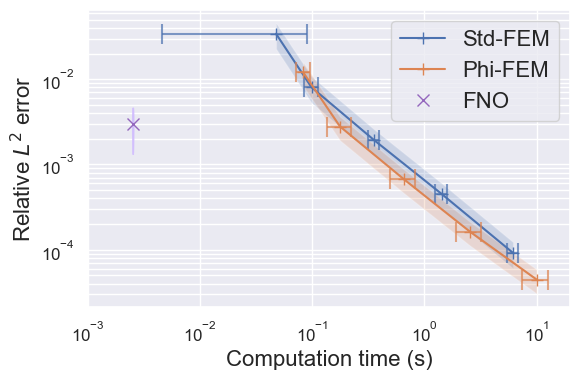

In [20]:
mean_times_L2_phi_fem = np.mean(Total_time_phi_fem_array, axis=0)
mean_times_L2_std_fem = np.mean(Total_time_std_fem_array, axis=0)
mean_times_L2_FNO = np.mean(Time_fno_array, axis=0)

std_times_L2_phi_fem = np.std(Total_time_phi_fem_array, axis=0)
std_times_L2_std_fem = np.std(Total_time_std_fem_array, axis=0)
std_times_L2_FNO = np.std(Time_fno_array, axis=0)

min_times_L2_phi_fem = np.min(Total_time_phi_fem_array, axis=0)
min_times_L2_std_fem = np.min(Total_time_std_fem_array, axis=0)
min_times_L2_FNO = np.min(Time_fno_array, axis=0)

max_times_L2_phi_fem = np.max(Total_time_phi_fem_array, axis=0)
max_times_L2_std_fem = np.max(Total_time_std_fem_array, axis=0)
max_times_L2_FNO = np.max(Time_fno_array, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ci_error_std_FEM = std_errors_L2_std_fem
ci_time_std_FEM = std_times_L2_std_fem

ax.loglog(
    mean_times_L2_std_fem,
    mean_errors_L2_std_fem,
    "-+",
    markersize=8,
    label="Std-FEM",
)
ax.fill_between(
    mean_times_L2_std_fem,
    mean_errors_L2_std_fem - ci_error_std_FEM,
    mean_errors_L2_std_fem + ci_error_std_FEM,
    alpha=0.2,
)
ax.errorbar(
    mean_times_L2_std_fem,
    mean_errors_L2_std_fem,
    xerr=ci_time_std_FEM,
    ecolor=sns.color_palette()[0],
    capsize=7,
    elinewidth=1.5,
    capthick=1.5,
    fmt="none",
    alpha=0.7,
)

ax.loglog(
    mean_times_L2_phi_fem,
    mean_errors_L2_phi_fem,
    "-+",
    markersize=8,
    label="Phi-FEM",
)

ci_error_phi_FEM = std_errors_L2_phi_fem
ci_time_phi_FEM = std_times_L2_phi_fem

ax.fill_between(
    mean_times_L2_phi_fem,
    mean_errors_L2_phi_fem - ci_error_phi_FEM,
    mean_errors_L2_phi_fem + ci_error_phi_FEM,
    alpha=0.2,
)
ax.errorbar(
    mean_times_L2_phi_fem,
    mean_errors_L2_phi_fem,
    xerr=ci_time_phi_FEM,
    ecolor=sns.color_palette()[1],
    capsize=7,
    elinewidth=1.5,
    capthick=1.5,
    fmt="none",
    alpha=0.7,
)

ax.plot(
    mean_times_L2_FNO[-1],
    mean_errors_L2_FNO[-1],
    "x",
    markersize=8,
    label="FNO",
    color=sns.color_palette("tab10")[4],
)
confidence_ellipse(
    Time_fno_array[:, -1],
    L2_error_fno_array[:, -1],
    ax,
    alpha=0.8,
    facecolor=sns.color_palette("pastel")[4],
    edgecolor=sns.color_palette("pastel")[4],
)


ax.legend(fontsize=16, loc="upper right")
ax.set_xlabel("Computation time (s)", fontsize=16)
ax.set_ylabel("Relative $L^2$ error", fontsize=16)
plt.grid(axis="y", visible=True, which="both")
plt.xlim(1e-3, 2e1)
plt.grid(axis="x", visible=True, which="major")

plt.tight_layout()
if save_figs:
    plt.savefig(f"{images_repo}/error_time_3_methods.png")
plt.show()

# Computation times for different sizes of input

In [ ]:
X, Y, x_normed, Y_normed, Y_pred_normed, X_val_normed = (
    None,
    None,
    None,
    None,
    None,
    None,
)
F, phi, G, domain, params = None, None, None, None, None
error, magnitude, error_inf, magnitude_inf = None, None, None, None
model, data = None, None  # clear memory
gc.collect()
torch.cuda.empty_cache()  # PyTorch thing

data = DataLoader(small_data)
model = FNO2d(3, 10, 20).to(device)

best_model = torch.load(f"./{models_repo}/best_model.pkl")
model.load_state_dict(best_model["model_state_dict"])
model.eval()


times, nb_data_call = [], []
times_phi_fem, times_std_fem = [], []

nb_input_list = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
nb_data = nb_input_list[-1]
F, phi, G, params = create_FG_numpy(nb_data, 64)


def average_time_standard_fem(params):
    total_time = 0.0
    for param in params:
        standard_solver = StandardFEMSolver(params=np.array([param]))
        (
            u_std,
            _h_std,
            construction_time_standard,
            resolution_time_standard,
        ) = standard_solver.solve_one(0, 0.0224, reference_fem=False)
        build_mesh = np.sum(construction_time_standard[:-3])

        total_time += build_mesh + resolution_time_standard
    average_time = total_time / len(params)
    return average_time


def average_time_phi_fem(params):
    total_time = 0.0
    for param in params:
        solver = PhiFemSolver_error(nb_cell=64 - 1, params=np.array([param]))
        (
            u_phi_fem,
            V_phi_fem,
            dx_phi_fem,
            _h_phi,
            cell_selection_phi,
            submesh_construction_phi,
            ghost_cell_selection_phi,
            resolution_time_phi,
        ) = solver.solve_one(0)

        total_time += (
            cell_selection_phi
            + submesh_construction_phi
            + ghost_cell_selection_phi
            + resolution_time_phi
        )
    average_time = total_time / len(params)
    return average_time


def compute_times_FNO(X):
    x_normed = data.x_normalizer.encode(X)
    start_call = time.time()
    Y_normed = model(x_normed)
    end_call = time.time()
    time_fno = end_call - start_call
    return time_fno


average_std_fem = average_time_standard_fem(params[:20])
average_phi_fem = average_time_phi_fem(params[:20])

ratio_std_fem, ratio_phi_fem = [], []
times_std, times_phi, times_fno = [], [], []
for nb_input in nb_input_list:
    times_std.append(nb_input * average_std_fem)
    times_phi.append(nb_input * average_phi_fem)
    X = generate_manual_new_data_numpy(
        F[:nb_input, :, :], phi[:nb_input, :, :], G[:nb_input, :, :]
    ).to(device)
    print(X.shape)
    time_fno = compute_times_FNO(X)
    times_fno.append(time_fno)
    ratio_std_fem.append(times_std[-1] / times_fno[-1])
    ratio_phi_fem.append(times_phi[-1] / times_fno[-1])
plt.figure(figsize=(6, 4))
plt.loglog(nb_input_list, times_std, "-+", label="Std-FEM")
plt.loglog(nb_input_list, times_phi, "-+", label=r"$\phi$-FEM")
plt.loglog(nb_input_list, times_fno, "-+", label="FNO")
plt.legend(fontsize=16)
plt.ylabel("Computation time (s)", fontsize=16)
plt.xlabel("Number of input data", fontsize=16)
plt.grid(axis="y", visible=True, which="both")
plt.tight_layout()
plt.savefig(f"./{images_repo}/compare_computation_times")
plt.show()


plt.figure(figsize=(6, 4))
plt.loglog(nb_input_list, ratio_std_fem, "-+", label="Std-FEM / FNO")
plt.loglog(nb_input_list, ratio_phi_fem, "-+", label=r"$\phi$-FEM / FNO")
plt.legend(fontsize=16)
plt.ylabel("Computation time ratio", fontsize=16)
plt.xlabel("Number of input data", fontsize=16)
plt.grid(axis="y", visible=True, which="both")
plt.tight_layout()
plt.savefig(f"./{images_repo}/compare_computation_times_ratio")
plt.show()